# Food Vision Big Classifier

**Introduction**

This project focuses on developing a machine learning model for classifying types of food from photographs. The goal is to build a robust image classification system capable of accurately identifying different food categories based on visual features. To train and evaluate the model, we utilized the Food-101 dataset, a comprehensive collection of food images sourced from Kaggle. This dataset comprises 101 distinct classes of food, providing a diverse and challenging benchmark for training and testing the model's performance. 

*Download data here:* https://www.kaggle.com/datasets/dansbecker/food-101

## Data preparation

Now let's see what the different images in our folder look like

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
# Function to show random images from folders
def show_random_images_from_folders(directory_path):
    folders = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
    selected_folders = random.sample(folders, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for ax, folder_name in zip(axes.flatten(), selected_folders):
        folder_path = os.path.join(directory_path, folder_name)
        images = [name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]
        img_name = random.choice(images)
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)       
        ax.imshow(img)
        ax.set_title(folder_name)
        ax.axis('off')   
    plt.show()

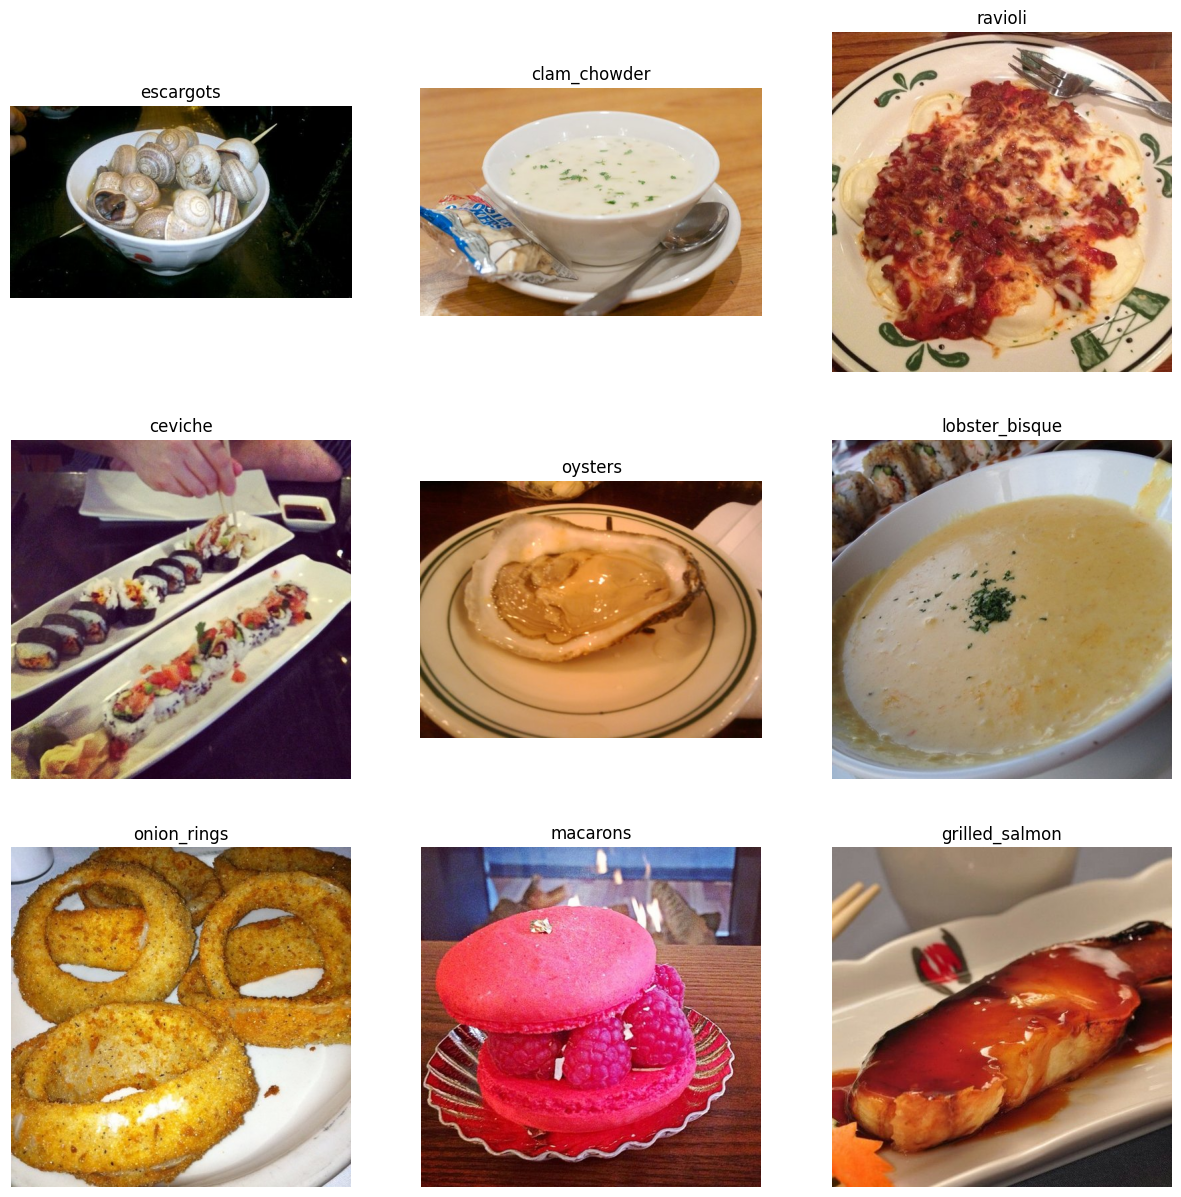

In [3]:
directory_path = 'food-101-images'
show_random_images_from_folders(directory_path)

In [4]:
# Get class names and print first 5
class_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [5]:
def get_image_paths_and_labels(directory_path):
    class_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
    image_paths = []
    labels = []
    
    for class_name in class_names:
        folder_path = os.path.join(directory_path, class_name)
        images = [os.path.join(folder_path, name) for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]
        image_paths.extend(images)
        labels.extend([class_name] * len(images))
    
    return image_paths, labels
image_paths, labels = get_image_paths_and_labels(directory_path)

## Data preprocessing

**Note:**\
For the model we will use an EfficientNetBX architecture. This model has a built-in rescaling layer, which automatically scales input pixel values to the range required by the network. Therefore, we can skip the manual rescaling step (e.g., dividing pixel values by 255). This simplifies our preprocessing pipeline and avoids redundant operations.

### Encode lables

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encode_labels = label_encoder.fit_transform(labels)

### Train, validation, test split

In [7]:
from sklearn.model_selection import train_test_split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, 
                                                                      encode_labels, 
                                                                      test_size=0.3, 
                                                                      random_state=101)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, 
                                                                  temp_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=101)
print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Number of testing images: {len(test_paths)}")

Number of training images: 70700
Number of validation images: 15150
Number of testing images: 15150


### Batch and prepare datasets

#### Image Preprocessing Function

In [8]:
import tensorflow as tf
# Function to load and preprocess an image
def preprocess_image(image_path, label, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, img_size)  
    return image, label

Let's check how works `preprocess_image` function and visualize for example second photo from train data

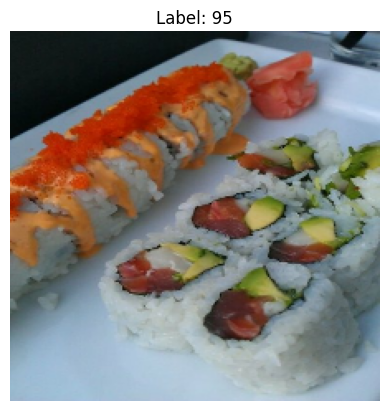

In [9]:
image, label = preprocess_image(train_paths[2], train_labels[2])
image_np = image.numpy().astype("uint8") 
plt.imshow(image_np)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

####  Create TensorFlow Datasets

Combine the image paths and labels into a TensorFlow dataset.Shuffle, Batch, and Prefetch

In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)  
train_dataset = train_dataset.map(lambda path, label: preprocess_image(path, label, IMG_SIZE))
# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) Make that after augmentation

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE) 
val_dataset = val_dataset.map(lambda path, label: preprocess_image(path, label, IMG_SIZE))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)  
test_dataset = test_dataset.map(lambda path, label: preprocess_image(path, label, IMG_SIZE))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Verify the Dataset

In [11]:
for images, lbls in train_dataset.take(1):  
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", lbls.shape)

Image batch shape: (224, 224, 3)
Labels batch shape: ()


### Data Augmentation

In [12]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image, label

train_dataset_augmented = train_dataset.map(augment_image)
train_dataset_augmented = train_dataset_augmented.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Check how our augmentation works on images from `train_paths` and `train_labels`

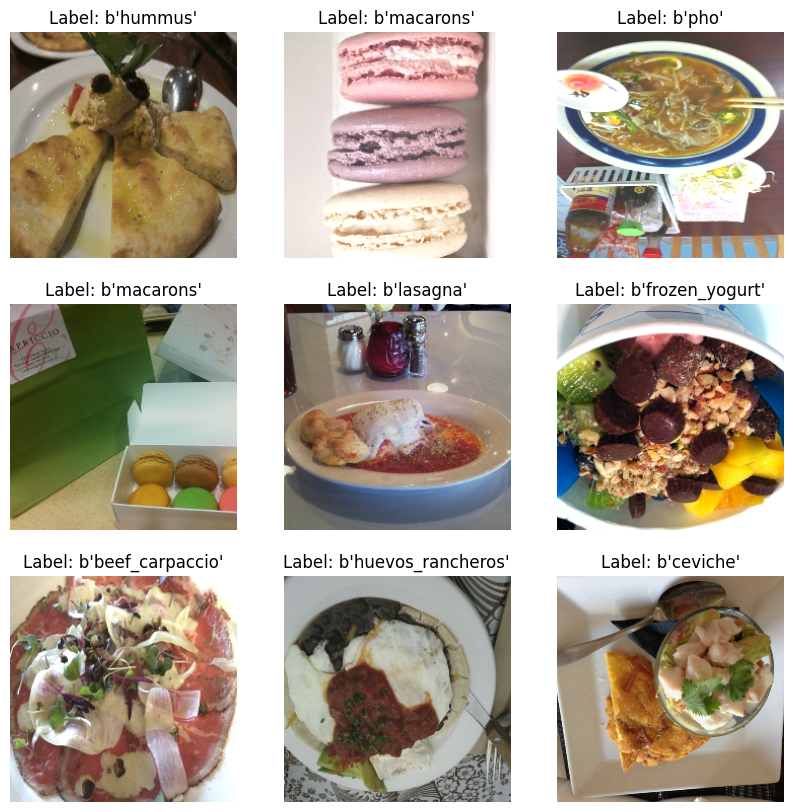

In [13]:
# Function to preprocess a single image
def preprocess_single_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, IMG_SIZE)   
    image = image / 255.0                         
    return image

# Function to generate and plot 9 augmented images using the augment_image function
def plot_9_random_augmented_images(paths, labels):
    indices = tf.random.shuffle(tf.range(len(paths)))[:9] 
    selected_paths = tf.gather(paths, indices)             
    selected_labels = tf.gather(labels, indices)           

    plt.figure(figsize=(10, 10))
    for i in range(9):
        # Preprocess the image
        image = preprocess_single_image(selected_paths[i])
        label = selected_labels[i]
        
        # Apply augmentation
        augmented_image, _ = augment_image(image, label)

        # Clip pixel values to [0, 1]
        augmented_image = tf.clip_by_value(augmented_image, clip_value_min=0.0, clip_value_max=1.0)

        # Convert to numpy for plotting
        augmented_image = augmented_image.numpy()

        # Plot the augmented image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
    plt.show()

# Example usage
plot_9_random_augmented_images(image_paths, labels)

Good

### Create a ModelCheckpoint

Saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it.Also give an opportunity to start fine-tuning a model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy", 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   verbose=0) 

### Setup mixed precision training

Mixed Precision Training is a technique that uses both `float16` (half-precision) and `float32` (full-precision) data types during model training. By doing so, it takes advantage of the GPU's capabilities to process data faster and more efficiently, especially with models like `EfficientNetB0`, which have many layers. This method reduces memory usage and speeds up the training process without significantly affecting model accuracy.

In [15]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

## Build feature extraction model 

##### Why use `EfficientNetB0`?
Given that my dataset has only 101,000 images, it’s more practical to use EfficientNetB0 instead of higher versions like EfficientNetB1 or B2. These higher versions have more parameters and require more data to perform optimally, which is unnecessary for a smaller dataset. EfficientNetB0 provides a good balance between accuracy and efficiency with fewer parameters, making it suitable for this amount of data.

In [16]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

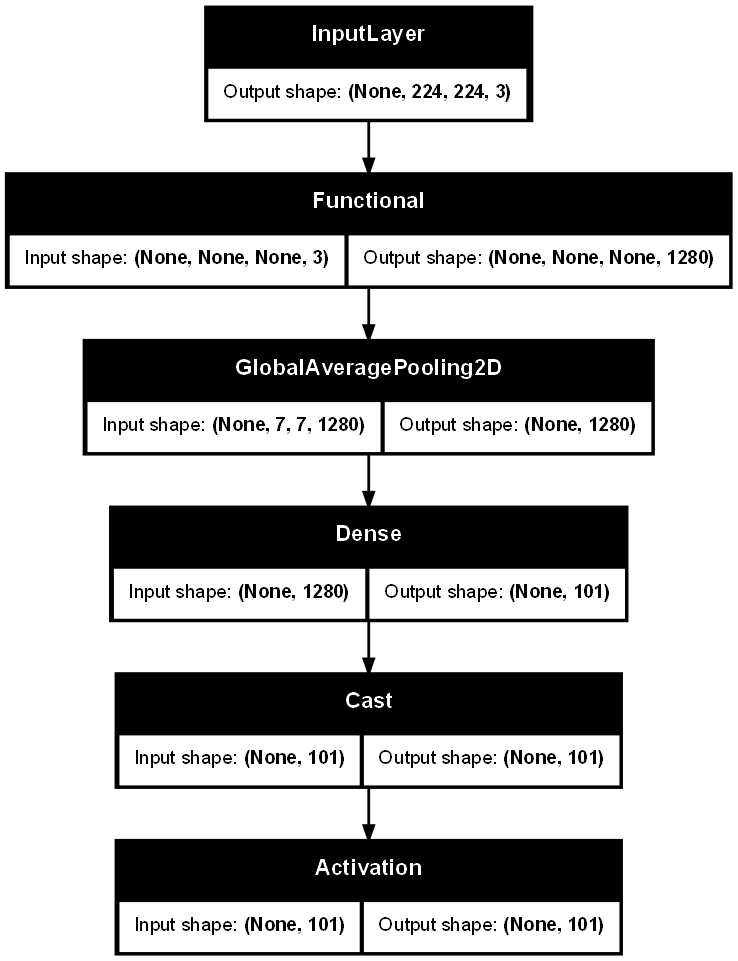

In [17]:
# Plot the tribid model
from keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=100)